# 자연처리 프레임워크 및 라이브러리 설치하기

In [1]:
# colab에 Mecab설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [2]:
%cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [3]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 7.6 MB/s 
     |████████████████████████████████| 448 kB 62.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-07-22 05:52:04--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=bz7f%2BzFtgGa6HeNQWqTaRB%2BtpmY%

In [4]:
# 필요 프레임워크 및 라이브러리 준비
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 로드

In [7]:
# 사전에 정제+정규화된 훈련용 통합 데이터 로드
total_data = pd.read_table('clean_naver_shopping_review_total_data.txt')

In [8]:
print(len(total_data))
print(total_data[:5])

199908
   ratings                                           document  label
0        2                              입고다니기 좀그래요 실내에서만 입으세요      0
1        4  포장박스가 살짝오픈되어 있어서 조금 그랬는데 상품은 이상없었고 예상했던맛이며 공복에...      1
2        2         직원분 실수로 잘못 배달되어져서 간장소스거 와버렸죠그래도 와사비는 맛좋으네요      0
3        2                                색은 괜찮은데 얇아서 금방 구멍나요      0
4        2                        재구매 가격이 시중에사는것보다 비싸서 부담스럽네요      0


# 토큰화

In [9]:
# 불용어 파일 로드
import os
data =  open('sentiment_stopwords_v0.2.txt', 'r', encoding='utf-16')
stopwords = []
for line in data :
    line.rstrip()
    stopwords.append(line.replace("\t\n", ""))
print(len(stopwords))
print(stopwords)

772
['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를들면', '예를들자면', '저', '소인', '소생', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수없다', '해서는안된다', '뿐만아니라', '만이아니다', '만은아니다', '막론하고', '관계없이', '그치지않다', '그러나', '그런데', '하지만', '든간에', '논하지않다', '따지지않다', '설사', '비록', '더라도', '아니면', '만못하다', '하는편이낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이외에', '이밖에', '하여야', '비로소', '한다면몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할생각이다', '하려고하다', '이리하여', '그리하여', '그렇게함으로써', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '그렇지만', '이외에도', '대해말하자면', '다음에', '반대로', '반대로말하자면', '이와반대로', '바꾸어서말하면', '바꾸어서한다면', '만약', '그렇지않으면', '까악', '툭', '딱', '삐걱

In [10]:
# 훈련데이터에 형태소 분석기를 사용하여 토큰화를 하면서 불용어 제거
mecab = Mecab()
X_total = []
for sentence in total_data['document']:
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_total.append(temp_X)

In [11]:
print(len(X_total))
print(X_total[:5])

199908
[['입', '다니', '그래요', '실내', '입', '으세요'], ['포장', '박스', '살짝', '오픈', '어서', '그랬', '는데', '상품', '었', '예상', '했', '던', '맛', '며', '공복', '꼭꼭', '씹', '먹', '으니', '혈당', '빠르', '올라가', '만족', '스러웠'], ['직원', '분', '실수', '잘못', '배달', '져서', '간장', '소스', '와버렸', '죠', '와사비', '맛', '으', '네요'], ['괜찮', '얇', '아서', '금방', '구멍나'], ['재', '가격', '시중', '비싸', '부담', '스럽', '네요']]


# 정수 인코딩

In [12]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 데이터를 정수로 변환
# 일단 단어 집합을 만들자
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_total)
 # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.
 # 단어 빈도수가 높은순으로 낮은 정수 인덱스 부여

In [17]:
# 등장 빈도수가 낮은 데이터를 처리해보자
# 특정 횟수 이하 단어의 비중이 몇인지 체크
threshold = 14
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45240
등장 빈도가 13번 이하인 희귀 단어의 수: 37361
단어 집합에서 희귀 단어의 비율: 82.5839964633068
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.945181980716592


In [18]:
# 전체 단어 개수 중 빈도수 12이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7880


In [19]:
# 단어집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환
#Tokenizer메서드에 숫자를 입력하면 빈도수가 높은 상위 몇개 단어만 사용
tokenizer = Tokenizer(num_words = vocab_size +2, oov_token ='OOV')
# 빈도수 상위 vocab_size단어만 사용, 숫자 0과 OOV를 고려해서 단어 집합의 크기는 +2
tokenizer.fit_on_texts(X_total)
# 여기까지는 보캡길이가 적용안된 것처럼 보임, 실제 적용은 text_to_sequences사용시 적용됨
X_total = tokenizer.texts_to_sequences(X_total)

# vocab_size로 지정한 단어만 보존하고 싶을 때, 굳이 안해도됨
# words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1] # 인덱스가 5 초과인 단어 제거
# for w in words_frequency:
#     del tokenizer.word_index[w] # 해당 단어에 대한 인덱스 정보를 삭제
#     del tokenizer.word_counts[w] # 해당 단어에 대한 카운트 정보를 삭제

# 정수인코딩 결과 확인
print(len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.word_counts)

# 빈도수 상위 vocabsize개수의 단어는 2 ~ vocabsize+1까지의 인덱스를 가졌으며, 그 외 단어 집합에 없는 단어들은 전부 'OOV'의 인덱스인 1로 인코딩
# 케라스 토크나이저는 기본적으로 'OOV'의 인덱스를 1로 지정
# print('단어 OOV의 인덱스 : {}'.format(tokenizer.word_index['OOV']))

45241
{'OOV': 1, '네요': 2, '어요': 3, '는데': 4, '아요': 5, '했': 6, '먹': 7, '합니다': 8, '재': 9, '쓰': 10, '해서': 11, '사용': 12, '았': 13, '었': 14, '겠': 15, '아서': 16, '그냥': 17, '제품': 18, '어서': 19, '가격': 20, '만족': 21, '입니다': 22, '맛': 23, '할': 24, '많이': 25, '사이즈': 26, '샀': 27, '빠르': 28, '왔': 29, '별로': 30, '맛있': 31, '포장': 32, '입': 33, '맞': 34, '던': 35, '저렴': 36, '괜찮': 37, '세요': 38, '넘': 39, '못': 40, '상품': 41, '정말': 42, '에요': 43, '냄새': 44, '부분': 45, '감사': 46, '아주': 47, '인데': 48, '긴': 49, '진짜': 50, '으면': 51, '보내': 52, '구입': 53, '구요': 54, '반품': 55, '아직': 56, '느낌': 57, '맘': 58, '써': 59, '다고': 60, '불편': 61, '깔끔': 62, '봤': 63, '달': 64, '비': 65, '완전': 66, '엄청': 67, '편하': 68, '건': 69, '쓸': 70, '은데': 71, '넣': 72, '다가': 73, '려고': 74, '처음': 75, '사진': 76, '디자인': 77, '효과': 78, '튼튼': 79, '상태': 80, '빠른': 81, '선물': 82, '랑': 83, '굿': 84, '분': 85, '대비': 86, '추천': 87, '얇': 88, '색상': 89, '길': 90, '싸': 91, '신': 92, '엔': 93, '귀찮': 94, '싼': 95, '기대': 96, '실망': 97, '더니': 98, '째': 99, '산': 100, '교환': 101, '계속': 102, '건지': 103,

In [20]:
y_total = np.array(total_data['label'])

# 빈 샘플(empty samples)제거

In [21]:
# 각 샘플의 길이가 0인 샘플들의 인덱스 확인
drop_total = [index for index, sentence in enumerate(X_total) if len(sentence) < 1]
print(len(drop_total))
print(drop_total)

150
[1184, 2608, 2898, 2922, 3210, 5700, 8324, 8599, 9922, 12194, 12767, 13528, 15307, 15823, 15859, 16293, 17264, 18941, 19421, 19682, 20613, 22673, 25582, 27982, 28109, 30117, 30702, 30943, 31159, 32567, 34211, 35208, 37471, 37743, 38767, 40878, 41626, 42047, 45472, 47404, 49783, 50507, 50893, 55092, 55543, 57466, 59462, 62627, 64770, 65006, 69187, 71095, 72802, 74538, 75204, 76352, 76895, 76990, 78456, 79064, 81645, 82264, 82456, 85761, 85862, 86856, 88399, 89798, 91424, 92101, 94425, 97820, 99348, 99584, 101030, 102712, 106216, 106275, 106721, 107394, 112572, 113199, 113216, 113521, 114636, 116501, 120200, 120507, 120991, 122278, 123473, 123763, 124157, 125459, 128511, 131948, 132745, 135234, 135600, 136986, 138098, 138932, 139077, 140405, 142529, 145024, 145060, 148053, 149286, 154617, 154636, 154894, 155165, 155188, 157699, 158893, 161036, 161844, 163758, 163971, 164485, 164863, 165212, 165227, 165792, 165866, 165960, 166059, 166085, 166638, 171225, 172422, 173551, 173751, 173918

In [22]:
# 빈 샘플들을 제거
X_total = np.delete(X_total, drop_total, axis=0)
y_total = np.delete(y_total, drop_total, axis=0)
print(len(X_total))
print(len(y_total))

199758
199758


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 82
리뷰의 평균 길이 : 9.808373131489102


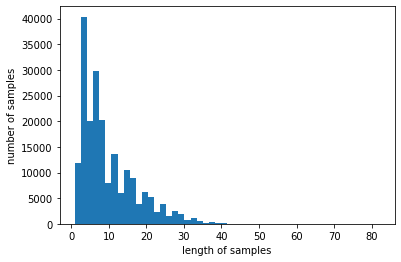

In [23]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰는 작업
# 전체 데이터에서 가장 길이가 긴 리뷰와, 전체의 길이분포를 알아보자
print('리뷰의 최대 길이 :',max(len(l) for l in X_total))
print('리뷰의 평균 길이 :',sum(map(len, X_total))/len(X_total))
plt.hist([len(s) for s in X_total], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
# 최적의 길이를 찾기 위해, 전체 샘플중 길이가 max_len 이하인 샘플의 비율을 확인하는 함수 생성
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [25]:
# 비율 체크
max_len = 25
below_threshold_len(max_len, X_total)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 95.44248540734289


In [26]:
# 짧은 데이터는 0을 채우고, 기준을 넘는 데이터는 손실됨
X_total = pad_sequences(X_total, maxlen = max_len)

# GRU 모델 훈련

In [27]:
# 필요한 프레임워크 및 라이브러리 임포트
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
model_GRU = Sequential()
model_GRU.add(Embedding(vocab_size+2, 100))
model_GRU.add(GRU(128))
model_GRU.add(Dense(1, activation='sigmoid'))

In [30]:
# 검증 데이터 손실이 4회 증가하면 학습 조기 종료
# model check point를 사용하여 검증 데이터의 정확도가 이전보다 좋아질 경우만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc_GRU = ModelCheckpoint('RNN_GRU_KoNLPy(Mecab)_Total(movie+shopping+game)_v0.5.1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [31]:
# 필요한 매트릭 선언, AUC-ROC, F1-Score, AUC-PR 에 필요한 지표 모두 체크
import tensorflow as tf

ROCauc = tf.keras.metrics.AUC(curve="ROC") # auc_1
PRauc = tf.keras.metrics.AUC(curve="PR") # auc_2
RECALL = tf.keras.metrics.Recall()
PRECISION = tf.keras.metrics.Precision()
TP = tf.keras.metrics.TruePositives()
TN = tf.keras.metrics.TrueNegatives()
FP = tf.keras.metrics.FalsePositives()
FN = tf.keras.metrics.FalseNegatives()

In [32]:
# GRU모델 훈련
model_GRU.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', ROCauc, PRauc, RECALL, PRECISION, TP, TN, FP, FN])
history = model_GRU.fit(X_total, y_total, epochs=15, callbacks=[es, mc_GRU], batch_size=100, validation_split=0.2)

Epoch 1/15
1599/1599 [==============================] - 24s 11ms/step - loss: 0.3334 - acc: 0.8606 - auc: 0.9316 - auc_1: 0.9238 - recall: 0.8695 - precision: 0.8546 - true_positives: 69549.0000 - true_negatives: 67980.0000 - false_positives: 11836.0000 - false_negatives: 10441.0000 - val_loss: 0.3068 - val_acc: 0.8755 - val_auc: 0.9422 - val_auc_1: 0.9351 - val_recall: 0.8881 - val_precision: 0.8654 - val_true_positives: 17674.0000 - val_true_negatives: 17303.0000 - val_false_positives: 2748.0000 - val_false_negatives: 2227.0000

Epoch 00001: val_acc improved from -inf to 0.87548, saving model to RNN_GRU_KoNLPy(Mecab)_Total(movie+shopping+game)_v0.5.1.h5
Epoch 2/15
1599/1599 [==============================] - 17s 11ms/step - loss: 0.2897 - acc: 0.8824 - auc: 0.9480 - auc_1: 0.9424 - recall: 0.8904 - precision: 0.8766 - true_positives: 71222.0000 - true_negatives: 69788.0000 - false_positives: 10028.0000 - false_negatives: 8768.0000 - val_loss: 0.2952 - val_acc: 0.8800 - val_auc: 0.947

# GRU 모델 성능평가

In [33]:
# 평가용 토탈 데이터셋2(화장품+앱)

# 데이터 로드
total_data2 = pd.read_table('clean_total_data(app&cosmetic).txt')

# 토크나이징
X_test_total2 = []
for sentence in total_data2['document']:
    temp_X2 = mecab.morphs(sentence)
    temp_X2 = [word for word in temp_X2 if not word in stopwords]
    X_test_total2.append(temp_X2)

# 워드 벡터화
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_test_total2)
X_test_total2 = tokenizer.texts_to_sequences(X_test_total2)

# 패딩
X_test_total2 = pad_sequences(X_test_total2, maxlen = max_len)

# 라벨데이터 포함
y_test_total2 = np.array(total_data2['label'])

In [34]:
# GRU모델 성능 평가 
loaded_model = load_model('RNN_GRU_KoNLPy(Mecab)_Total(movie+shopping+game)_v0.5.1.h5')
result = loaded_model.evaluate(X_test_total2, y_test_total2, batch_size=100)
print("\n GRU 테스트 결과:",result)

107/107 [==============================] - 2s 6ms/step - loss: 1.0842 - acc: 0.5000 - auc: 0.5272 - auc_1: 0.7175 - recall: 0.4663 - precision: 0.7227 - true_positives: 3477.0000 - true_negatives: 1837.0000 - false_positives: 1334.0000 - false_negatives: 3979.0000

 GRU 테스트 결과: [1.0842305421829224, 0.5000470280647278, 0.5272067189216614, 0.7174720764160156, 0.46633583307266235, 0.7227187752723694, 3477.0, 1837.0, 1334.0, 3979.0]
